# Exploratory Data Analysis



## Data Load

In [1]:
#required imports for the data analysis
import sqlite3
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import seaborn as sns

In [2]:
#setup connection to the database

mypath="D:\\Documents\\University\\7_semestre\\DM\\Project\\DataMiningFinalProject\\Data\\insurance.db"
conn=sqlite3.connect(mypath)
cursor=conn.cursor()

In [3]:
#Get information about tables from db
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
tables=pd.DataFrame(cursor.fetchall(), columns=[d[0] for d in cursor.description])

table_variables=[]
for i in tables.iloc[:,0]:
    table_variables.append([j.group().replace("\"", '') for j in re.finditer('\".*\"',i)])

table_variables

[['LOB',
  'index',
  'Customer Identity',
  'Premiums in LOB: Motor',
  'Premiums in LOB: Household',
  'Premiums in LOB: Health',
  'Premiums in LOB:  Life',
  'Premiums in LOB: Work Compensations'],
 ['Engage',
  'index',
  'Customer Identity',
  'First Policy´s Year',
  'Brithday Year',
  'Educational Degree',
  'Gross Monthly Salary',
  'Geographic Living Area',
  'Has Children (Y=1)',
  'Customer Monetary Value',
  'Claims Rate']]

## Data Assessment 

In [4]:
#Build Analytical Base Table (ABT)
abtquery="""SELECT e.'Customer Identity', e.'First Policy´s Year', e.'Brithday Year', e.'Educational Degree', 
            e.'Gross Monthly Salary', e.'Geographic Living Area', e.'Has Children (Y=1)', e.'Customer Monetary Value', 
            e.'Claims Rate', l.'Premiums in LOB: Motor', l.'Premiums in LOB: Household', l.'Premiums in LOB: Health', 
            l.'Premiums in LOB:  Life', l.'Premiums in LOB: Work Compensations'
            FROM LOB l, Engage e
            WHERE l.'Customer Identity'=e.'Customer Identity'"""
cursor.execute(abtquery)

#Variables alias
alias=["id","first_policy","birthday","education","salary","area","children","cmv","claims_r","motor","household","health","life","work_comp"]

df=pd.DataFrame(cursor.fetchall(), columns=alias)
conn.close()
df.head()

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
0,1,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [5]:
#Dimension of the dataset
df.shape

(10296, 14)

In [6]:
#Data types of the variables
df.dtypes

id                int64
first_policy    float64
birthday        float64
education        object
salary          float64
area            float64
children        float64
cmv             float64
claims_r        float64
motor           float64
household       float64
health          float64
life            float64
work_comp       float64
dtype: object

In [8]:
#Check if first_policy, birthday and salary are integers
for i in [df.first_policy.fillna(0), df.birthday.fillna(0), df.salary.fillna(0)]: #control for nans
    print(all(i.apply(lambda x: x.is_integer())))#will return True if all values of each series is an integer

True
True
True


In [9]:
#Correcting some data types
#"first_policy":int, "birthday":int, "salary":int, can't be converted due to NAs
df=df.astype({"area": object, "children": object})

In [10]:
#Get summary statistics from df
df.iloc[:,1:].describe(include='all')

,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
count,10266.000000,10279.000000,10279,10260.000000,10295.0,10275.0,10296.000000,10296.000000,10262.000000,10296.000000,10253.000000,10192.000000,10210.000000
unique,NaN,NaN,4,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3 - BSc/MSc,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4799,NaN,4145.0,7262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1991.062634,1968.007783,NaN,2506.667057,NaN,NaN,177.892605,0.742772,300.470252,210.431192,171.580833,41.855782,41.277514
std,511.267913,19.709476,NaN,1157.449634,NaN,NaN,1945.811505,2.916964,211.914997,352.595984,296.405976,47.480632,51.513572
min,1974.000000,1028.000000,NaN,333.000000,NaN,NaN,-165680.420000,0.000000,-4.110000,-75.000000,-2.110000,-7.000000,-12.000000
25%,1980.000000,1953.000000,NaN,1706.000000,NaN,NaN,-9.440000,0.390000,190.590000,49.450000,111.800000,9.890000,10.670000
50%,1986.000000,1968.000000,NaN,2501.500000,NaN,NaN,186.870000,0.720000,298.610000,132.800000,162.810000,25.560000,25.670000
75%,1992.000000,1983.000000,NaN,3290.250000,NaN,NaN,399.777500,0.980000,408.300000,290.050000,219.820000,57.790000,56.790000


In [11]:
#More info about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
id              10296 non-null int64
first_policy    10266 non-null float64
birthday        10279 non-null float64
education       10279 non-null object
salary          10260 non-null float64
area            10295 non-null object
children        10275 non-null object
cmv             10296 non-null float64
claims_r        10296 non-null float64
motor           10262 non-null float64
household       10296 non-null float64
health          10253 non-null float64
life            10192 non-null float64
work_comp       10210 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.1+ MB


In [12]:
#Check duplicates
any(df.duplicated())

False

In [13]:
#Number of missing values in each feature
df.isna().sum()

id                0
first_policy     30
birthday         17
education        17
salary           36
area              1
children         21
cmv               0
claims_r          0
motor            34
household         0
health           43
life            104
work_comp        86
dtype: int64

In [14]:
#Frequencies of number of missing values across rows
df.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    9987
1     256
2      38
3       3
4      12
dtype: int64

## Data Visualizations

<img src="./img/anatomy_of_figure.png"/>

In [15]:
#Define metric and non-metric datasets
metric= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="float64"))]
non_metric= df.loc[:,(df.columns=="id") | (np.array(df.dtypes=="object"))]

C:\Users\davids\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\davids\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


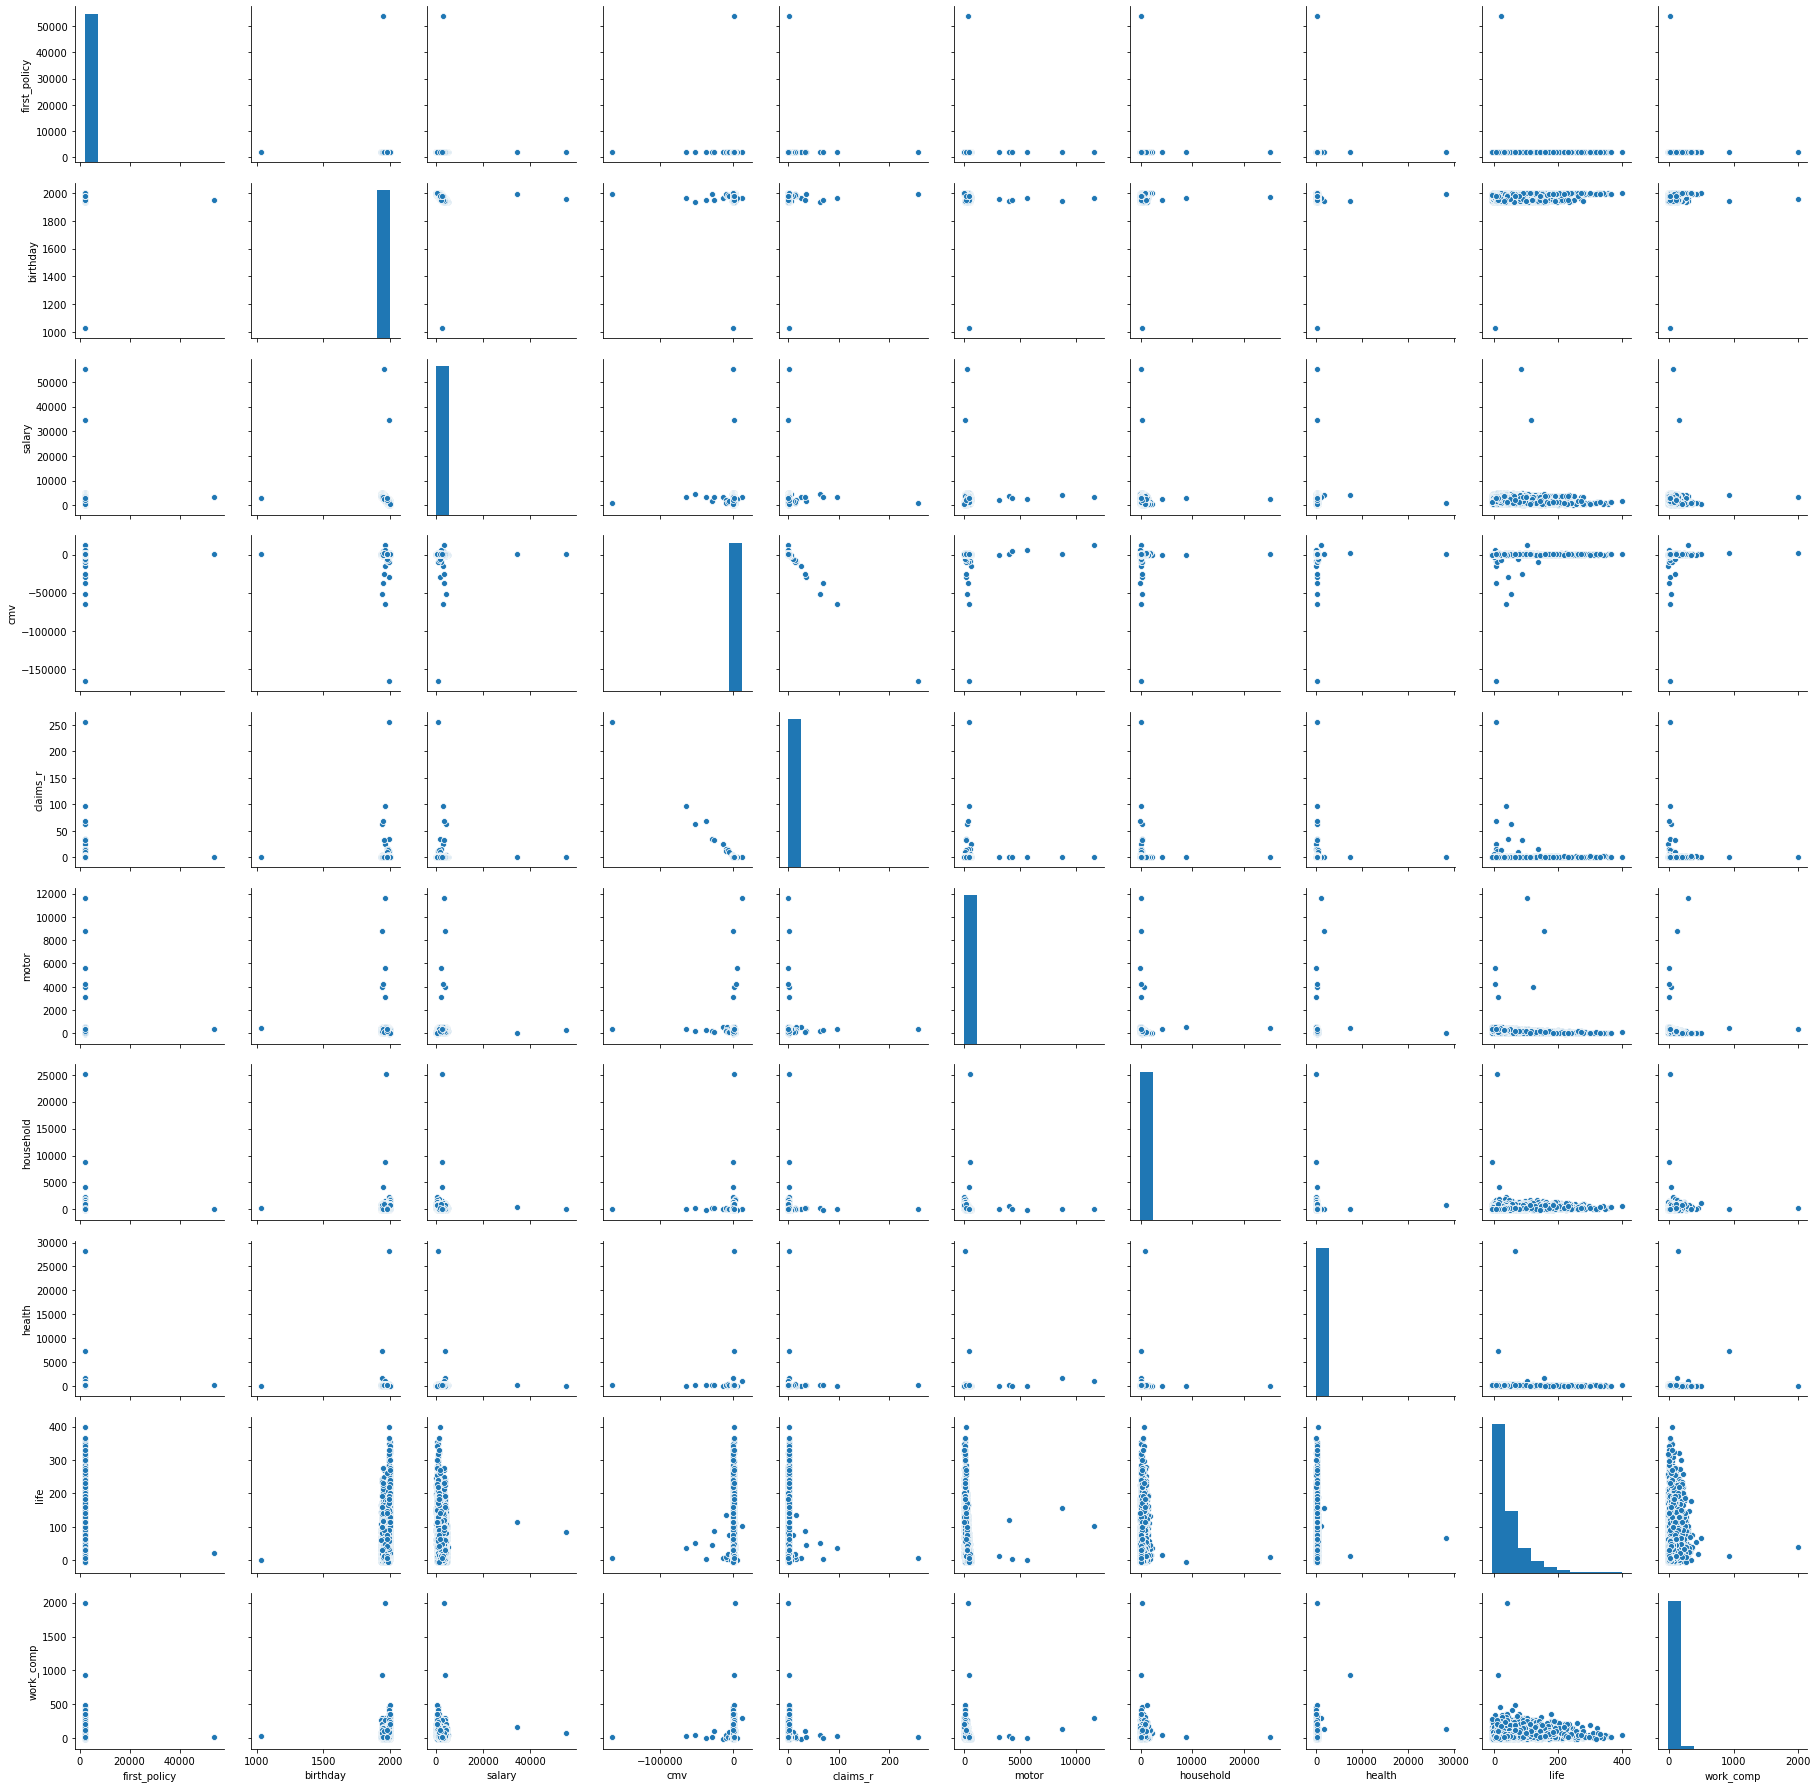

In [16]:
sns.pairplot(metric.drop("id",1))
plt.show()

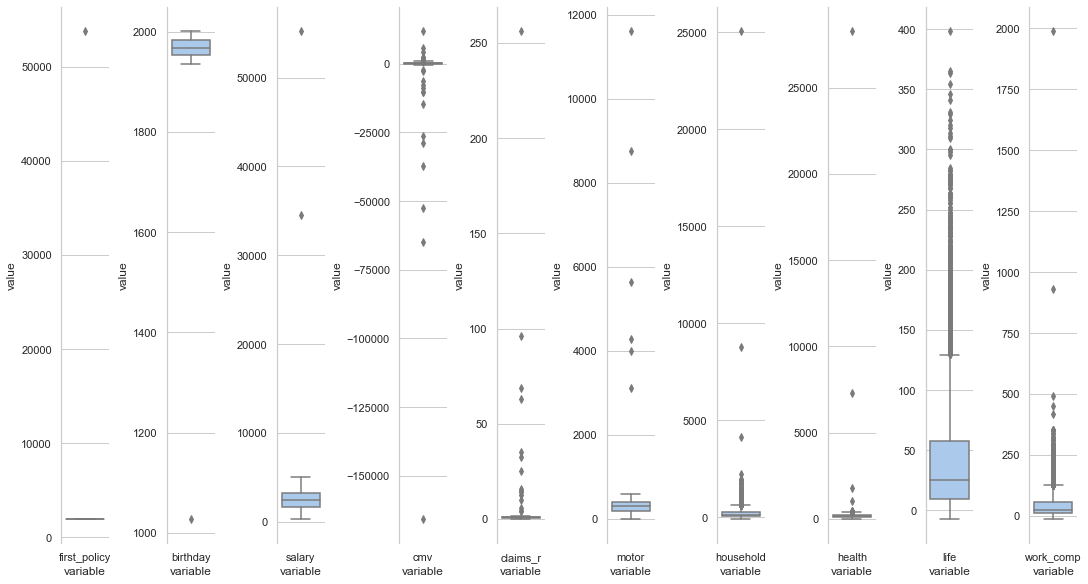

In [17]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
data=metric.melt("id")
plot_features= metric.drop("id",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    pdata= data.loc[data.loc[:,"variable"]==plot_f,:]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.boxplot(x="variable", y="value", data=pdata, ax=ax)

# Finalize the plot
sns.despine(bottom=True)
fig.set_size_inches(15, 8)

plt.show()

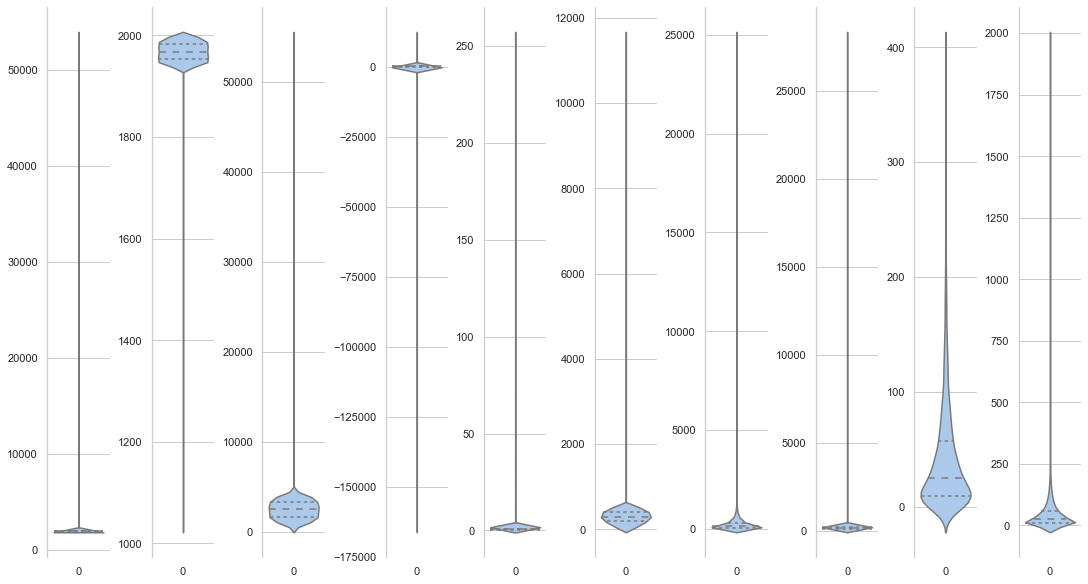

In [18]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Prepare dataframe layout
# viol_df= metric.melt(id_vars= "Customer Identity") #melt function unpivots dataframe into variable-value pairs identified by an id
plot_features= metric.drop("id",1).columns

#Prepare figure layout
fig= plt.figure(constrained_layout=True) #Create figure object
spec= gspec.GridSpec(ncols=len(plot_features), nrows=1, figure=fig) #Gridspec allows to define the grid structure which can  
                                                                    #then be populated through figure.add_subplot method
    
# Draw the violinplots and split the violins for easier comparison
for i, plot_f in enumerate(plot_features):
    ax= fig.add_subplot(spec[0,i])
    data= metric.drop("id",1).loc[:,plot_f]
#     viol_df.loc[viol_df.loc[:,"variable"]==plot_f,:] #Selecting every variable-value pair for a specific metric variable
    graph= sns.violinplot( inner="quart", data=data, ax=ax)

# Finalize the plot

sns.despine(bottom=True)
fig.set_size_inches(15, 8)

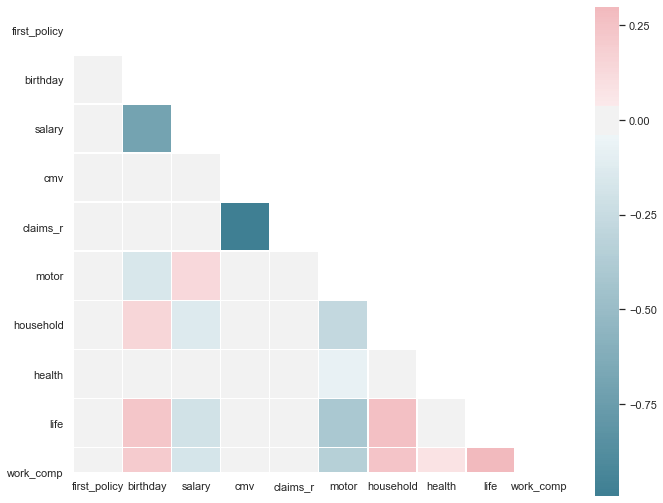

In [19]:
sns.set(style="white")

# Compute the correlation matrix
corr = metric.drop("id",1).corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5)

plt.show()

## Data cleaning

### Ideas
- see if mean of variables differs by area of living (t-test, pivot-table, ...)
- see the same for childs
- if cmv <0 and claims_r <1 then: bad customer (no pay); if cmv<0 and claims_r>1 then: prone to call insurance. Can we do thiss? claims_r is for the last 2 years and cmv is lifetime

### Coherence Checks
- first_policy >= birthday
- some constraint regarding age and education (e.g. people with phd should at least have more than 25 yo)?
- minors have salary?


In [29]:
df.loc[df.first_policy<df.birthday]

,id,first_policy,birthday,education,salary,area,children,cmv,claims_r,motor,household,health,life,work_comp
1,2,1981.0,1995.0,2 - High School,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
13,14,1983.0,2000.0,1 - Basic,1043.0,3,1,-75.12,1.06,44.34,342.85,127.69,267.94,94.46
18,19,1981.0,1982.0,1 - Basic,1414.0,3,1,230.38,0.71,313.17,373.40,121.80,14.78,72.57
22,23,1976.0,1986.0,2 - High School,1495.0,1,1,-89.79,1.08,209.04,308.95,192.48,64.79,54.90
40,41,1994.0,1995.0,2 - High School,1177.0,4,1,121.36,0.84,52.01,455.65,135.47,146.36,148.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10268,10269,1987.0,1988.0,3 - BSc/MSc,1414.0,3,1,50.46,0.90,129.58,167.80,184.48,165.92,75.46
10273,10274,1989.0,1992.0,2 - High School,1035.0,1,1,293.51,0.58,235.71,195.60,103.13,170.92,58.12
10284,10285,1980.0,1987.0,3 - BSc/MSc,1504.0,4,1,-1.55,0.96,390.63,29.45,179.70,-6.00,NaN
10288,10289,1982.0,1993.0,2 - High School,1465.0,1,1,795.15,0.35,67.79,820.15,102.13,182.48,86.46


In [15]:
df.groupby("age").mean().salary #minors have salary?

age
15.0     1017.916667
16.0      928.885714
17.0      990.289855
18.0      950.787234
19.0      994.431818
            ...     
78.0     4008.857143
79.0     3989.877193
80.0     4074.378378
81.0     4069.857143
988.0    2830.000000
Name: salary, Length: 68, dtype: float64

### Outliers

### Missing Values

## Feature Engineering
- Years as customer (YC)
- Years old (YO)
- YC/YO
- CMV/YC
- Total premiums
- Each premium/Total premiums
- Number of products= Number of non-zero premium columns

In [7]:
current_year=2016
years_customer= current_year-df.first_policy
age= current_year-df.birthday
years_customer_age= years_customer/age
cmv_years_customer= df.cmv/years_customer
t_premiums= df.loc[:,["motor","household","health","life","work_comp"]].apply(sum, axis=1)
perc_premiums= [df.loc[:,i]/t_premiums for i in ["motor","household","health","life","work_comp"]]